[View in Colaboratory](https://colab.research.google.com/github/KristianHiggins/fastaic1v3/blob/master/fastaic1v3e1.ipynb)

<h1>FastAI</h1>
<h2>Course 1. Version 3.</h2>
<a href="https://www.youtube.com/watch?v=7hX8yKCX6xM">Episode 1</a>


In [0]:
!kill -9 -1

In [2]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 575.6MB 21kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62514000 @  0x7fbc243152a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [3]:
!pip install fastai

    100% |████████████████████████████████| 102kB 7.4MB/s 
    100% |████████████████████████████████| 61kB 13.9MB/s 
    100% |████████████████████████████████| 13.9MB 2.3MB/s 
    100% |████████████████████████████████| 112kB 32.6MB/s 
    100% |████████████████████████████████| 112kB 28.3MB/s 
    100% |████████████████████████████████| 2.2MB 12.8MB/s 
torchvision-nightly 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


<h1>Lesson 1 - What's your pet</h1>
Welcome to lesson 1!

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
# 'Magics' to configure/reset notebook env.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the <a href="http://www.fast.ai/2018/10/02/fastai-ai/">fastai V1 library </a>which sits on top of <a href="https://hackernoon.com/pytorch-1-0-468332ba5163"> Pytorch 1.0 </a>. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import *

In [0]:
from fastai.vision import *

<h3>Looking at the data</h3>
We are going to use the <a href="http://www.robots.ox.ac.uk/~vgg/data/pets/">Oxford-IIIT Pet Dataset</a> by <a href="http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf">O. M. Parkhi et al., 2012</a>which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

<hr></hr>

We are going to use the untar_data function to which we must pass a URL as an argument and which will download and extract the data.


In [7]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None)
    Download `url` if doesn't exist to `fname` and un-tgz to folder `dest`



In [8]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

['images', 'annotations']

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, ImageDataBunch.from_name_re gets the labels from the filenames using a <a href="https://docs.python.org/3.6/library/re.html">regular expression</a>.

In [11]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_162.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_119.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_171.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_62.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_169.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

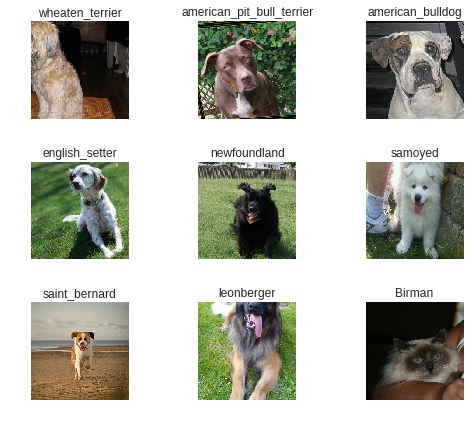

In [14]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
print(data.classes)
len(data.classes),data.c

['scottish_terrier', 'Maine_Coon', 'Bombay', 'german_shorthaired', 'chihuahua', 'Sphynx', 'Russian_Blue', 'samoyed', 'Persian', 'yorkshire_terrier', 'miniature_pinscher', 'staffordshire_bull_terrier', 'havanese', 'english_setter', 'beagle', 'Birman', 'leonberger', 'american_bulldog', 'pomeranian', 'wheaten_terrier', 'British_Shorthair', 'Bengal', 'boxer', 'Egyptian_Mau', 'shiba_inu', 'american_pit_bull_terrier', 'english_cocker_spaniel', 'pug', 'Siamese', 'Abyssinian', 'saint_bernard', 'great_pyrenees', 'japanese_chin', 'basset_hound', 'Ragdoll', 'keeshond', 'newfoundland']


(37, 37)

<h3>Training: resnet34</h3>
Now we will start training our model. We will use a <a href="http://cs231n.github.io/convolutional-networks/"> convolutional neural network </a> backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [16]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 37779344.17it/s]


In [17]:
learn.fit_one_cycle(4)

epoch  train loss  valid loss  error_rate


RuntimeError: ignored

In [0]:
learn.save('stage-1')

<h3>Results</h3>
Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

RuntimeError: ignored

In [18]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          40G   12G   26G  31% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G     0  6.4G   0% /var/colab
/dev/sda1        46G   14G   32G  31% /etc/hosts
shm              64M   60K   64M   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
